# Get Google and Watson API Results and store on file
-----

## Instantiate the Pipeline

In [20]:
%%time
import importlib
import pipeline
importlib.reload(pipeline)

cnd = pipeline.CND()

print([name for name in cnd.nlp.pipe_names])

['tagger', 'parser', 'ner', 'Named Entity Matcher', 'merge_entities', 'Concept Matcher']
Wall time: 19.7 s


## Instantiate the Dataset

In [21]:
%%time
import importlib
from IPython.display import clear_output
import cndobjects
importlib.reload(cndobjects)


dirpath = r'C:\\Users\\Steve\\OneDrive - University of Southampton\\CNDPipeline\\dataset'

orators = cndobjects.Dataset(cnd, dirpath)
clear_output(wait=True)

display(orators.summarise())

,,Name,Text Count,Word Count
Ref,,,,
hitler,0,Adolf Hitler,1,"706,100"
bush,1,George Bush,14,"143,936"
king,2,Martin Luther King,5,"122,815"
laden,3,Osama bin Laden,6,"93,646"
Totals,4,,26,"1,066,497"


Wall time: 42.3 s


## Get Google API Results

Get the data from the online API and store on file to save from repeated calls.

Authentication
- https://cloud.google.com/docs/authentication/getting-started

Dashboard
- https://console.cloud.google.com/home/dashboard?project=modern-heading-262419

Documents
- https://cloud.google.com/natural-language/docs/reference/rest

### Initiate API

In [ ]:
%%time
import os
# Imports the Google Cloud client library
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r""
# Instantiates a client
client = language.LanguageServiceClient()

### Get overall document analytics for the Google API

In [ ]:
%%time
import os
from tqdm import tqdm
import pickle

document_results = dict()

#instantiate dict() for each orator()
orators_dict = {}
    
# iterate through each orator() object
for ref, orator in orators.orators_dict.items():
    
    # instantiate orator dict()
    orators_dict[ref] = []
   
    
    # iterate over each Text() of the orator() object
    for text in tqdm(orator.texts, total = len(orator.texts), desc = ref):
    # instantiate document dict()
        document = dict()
        document["title"] = text.title
        document["analytics"] = []

        # Mein Kampf is too large for the Google API, the document sentiment is calculated using an average of sentence sentiments
        if ref == "hitler":
            document["analytics"].append(
                {"sentiment" : 0),
                 "entities" : '',
                 "classifications" : '',
                 "syntax" : ''
                })
            
            orators_dict[ref].append(document)
            break
        
        
        doc_obj = types.Document(
            content=str(text.doc.text),
            type=enums.Document.Type.PLAIN_TEXT)
        encoding_type = enums.EncodingType.UTF8

        document["analytics"] = {"sentiment" : client.analyze_sentiment(document=doc_obj).document_sentiment,
                                 "entities" : client.analyze_entity_sentiment(doc_obj, encoding_type=encoding_type),
                                 "classifications" : client.classify_text(doc_obj),
                                 "syntax" : client.analyze_syntax(doc_obj, encoding_type=encoding_type)
                                }
    
        # append the document object to the orator dict()
        orators_dict[ref].append(document)
        
    # append the orator dict() to the overall dataset
    document_results.update(orators_dict)
    
google_document_results = document_results
# time = 3min 51s

### Save the Google document object to file

the NLP objects for Google can't be stored as a json object, therefore they are serialised using pickle

In [ ]:
%%time

# import os
# import pickle
# filepath = os.getcwd()
# pickle_filename = "google_document_analytics"
# with open(os.path.join(filepath, pickle_filename), 'wb') as file:
#     pickle.dump(google_document_results, file)

### Get sentence level sentiment analytics for Google API

In [ ]:
%%time
import os
import pickle
from tqdm import tqdm
# instantiate dataset dictionary
sentence_sentiment = dict()

#instantiate dict() for each orator()
orators_dict = {}
    
for ref, orator in orators.orators_dict.items():
    
    # instantiate orator dict()
    orators_dict[ref] = list()
    
    # iterator through orator() texts
    for text in orator.texts:
        
        # instantiate document dict()
        document = dict()
        document["title"] = text.title
        document["sentiments"] = list()
        
        # iterator through each sentence of the text and append sentiment score to the sentiments list
        for sentence in tqdm(text.doc.sents, total = len(list(text.doc.sents)), desc = document["title"]):
            
            sent_obj = types.Document(
                content=str(sentence).strip(),
                type=enums.Document.Type.PLAIN_TEXT)
            document["sentiments"].append(client.analyze_sentiment(document=sent_obj).document_sentiment)
            
        # append the document object to the orator dict()
        orators_dict[ref].append(document)
    
    # append the orator dict() to the overall dataset
    sentence_sentiment.update(orators_dict)
    
google_sentence_sentiment = sentence_sentiment
# time = 27min 52s

### Get average sentence sentiment score for Google API

Since Mein Kampf is too large for Google's  open source API, the score is derived from an average of sentence sentiment scores.

This cell provides the code to get the average score for sentences within a document.

The difference between the document and average sentence sentiment is then shown. Without any kind of metric for sentiment, there is no way of assessing the significance of this difference.

In [6]:
from statistics import mean

# code for getting average sentence sentiment score
sentence_sentiment_mean = mean([sentiment.score for sentiment in google_sentence_sentiment["hitler"][0]["sentiments"]])

# check for differences between document and sentence level score
for ref, document in google_document_analytics.items():
    for text in range(len(document)):
        if ref == "hitler":
            continue
        doc_score = google_document_analytics[ref][text]["analytics"]["sentiment"].score 
        sent_score = mean([sentiment.score for sentiment in google_sentence_sentiment[ref][text]["sentiments"]])
        n = 2
        difference = round(abs(doc_score - sent_score), n)
        print(f"difference =  {difference}")



difference =  0.06
difference =  0.0
difference =  0.04
difference =  0.07
difference =  0.01
difference =  0.08
difference =  0.02
difference =  0.02
difference =  0.01
difference =  0.06
difference =  0.01
difference =  0.0
difference =  0.03
difference =  0.01
difference =  0.03
difference =  0.02
difference =  0.0
difference =  0.02
difference =  0.03
difference =  0.06
difference =  0.02
difference =  0.01
difference =  0.03
difference =  0.1
difference =  0.0


### Save the Google document object to file

the NLP objects for Google can't be stored as a json object, therefore they are serialised using pickle

In [ ]:
%%time
import os
import pickle

# filepath = os.getcwd()
# pickle_filename = "google_sentence_sentiment"
# with open(os.path.join(filepath, pickle_filename), 'wb') as file:
#     pickle.dump(google_sentence_sentiment, file)

### Get Google data from disk

In [22]:
%%time
import os
import pickle

google_document_analytics_filename = "google_document_analytics"
google_sentence_sentiment_filename = "google_sentence_sentiment"

filepath = os.getcwd()
with open(os.path.join(filepath, google_document_analytics_filename), 'rb') as file:
    google_document_analytics = pickle.load(file)
    
with open(os.path.join(filepath, google_sentence_sentiment_filename), 'rb') as file:
    google_sentence_sentiment = pickle.load(file)
    
print("doc analytics size:", len(google_document_analytics))
print("sentence sentiment size:", len(google_sentence_sentiment))

doc analytics size: 4
sentence sentiment size: 4
Wall time: 320 ms


## Get Watson API Results

Get the data from the online API and store on file to save from repeated calls.

API Documentation
- https://cloud.ibm.com/apidocs/natural-language-understanding

Source Code
- http://watson-developer-cloud.github.io/python-sdk/v1.0.2/_modules/watson_developer_cloud/natural_language_understanding_v1.html

### Initiate Watson API

In [3]:
%%time
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 import Features, ConceptsOptions, EmotionOptions, EntitiesOptions, KeywordsOptions, CategoriesOptions, SentimentOptions

apikey = ''
url = ''

authenticator = IAMAuthenticator(apikey)
service = NaturalLanguageUnderstandingV1(version='2019-07-12', authenticator=authenticator)
service.set_service_url(url)

Wall time: 116 ms


### Get overall document analytics for the Watson API

Generates output at the for all of Watson's natural langugage processing features.

Output object is in jsonlines format and stored to file.

In [ ]:
%%time
import os
from tqdm import tqdm
import json

# instantiate dataset dictionary
document_results = dict()

#instantiate dict() for each orator()
orators_dict = {}
    
# iterate through each orator() object
for ref, orator in orators.orators_dict.items():
    
    # instantiate orator dict()
    orators_dict[ref] = list()
   
    
    # iterate over each Text() of the orator() object
    for text in tqdm(orator.texts, total = len(orator.texts), desc = ref):
    # instantiate document dict()
        document = dict()
        document["title"] = text.title
        document["ref"] : text.ref
        document["targets"] = targets = list(set([str(ent) for ent in text.doc.ents if ent.label_ in ["GPE", "NORP", "ORG", "PERSON"]])),
        
        document["analytics"] = service.analyze(
                        text=str(text.doc.text),
                        features=Features(
                            concepts=ConceptsOptions(limit=50),
                            emotion=EmotionOptions(targets = targets),
                            entities=EntitiesOptions(emotion=True, sentiment=True),
                            keywords=KeywordsOptions(emotion=True, sentiment=True),
                            categories=CategoriesOptions(),
                            sentiment=SentimentOptions()
                        )).get_result()
        
        # append the document object to the orator dict()
        orators_dict[ref].append(document)
        
    # append the orator dict() to the overall dataset
    document_results.update(orators_dict)
    
watson_document_results = document_results
# time = 1m3s

### Save Watson document object to file

In [ ]:
%%time
# import json
# filepath = os.getcwd()
# json_filename = "watson_document_analytics.json"
# with open(os.path.join(filepath, json_filename), 'w') as file:
#     file.write(json.dumps(watson_document_results))

### Get sentence level sentiment analytics for Watson API

The output object uses the same structure as the orators dataset object.

In [ ]:
%%time
import json
import os
from tqdm import tqdm

# instantiate dataset dictionary
watson_sentiment = dict()

#instantiate dict() for each orator()
orators_dict = {}
for ref, orator in orators.orators_dict.items():
    
    # instantiate orator dict()
    orators_dict[ref] = list()
    
    # iterator through orator() texts
    for text in orator.texts:
        
        # instantiate document dict()
        document = dict()
        document["title"] = text.title
        document["sentiments"] = list()
        
        # iterator through each sentence of the text and append sentiment score to the sentiments list
        for sentence in tqdm(text.doc.sents, total = len(list(text.doc.sents))):
            
            ### remember this sentences key has changed from sentiments
            document["sentences"].append(service.analyze(
                text=str(sentence.text),
                features=Features(sentiment=SentimentOptions(),
                                 emotion=EmotionOptions()),
                language = "en").get_result())
            
        # aappend the document object to the orator dict()
        orators_dict[ref].append(document)
    
    # append the orator dict() to the overall dataset
    watson_sentiment.update(orators_dict)
# time = 1hr3min

### Write Watson data to disk

In [61]:
%%time
import os
import json

filepath = os.getcwd()
json_filename = "watson_sentence_sentiment.json"
with open(os.path.join(filepath, json_filename), 'w') as file:
    file.write(json.dumps(watson_sentiment))

Wall time: 112 ms


### Get Watson data from disk

In [24]:
%%time
import os
import json

watson_document_analytics_filename = "watson_document_analytics.json"
watson_sentence_sentiment_filename = "watson_sentence_sentiment.json"

filepath = os.getcwd()
with open(os.path.join(filepath, watson_document_analytics_filename), 'r') as file:
    watson_document_analytics = json.load(file)
    
with open(os.path.join(filepath, watson_sentence_sentiment_filename), 'r') as file:
    watson_sentence_sentiment = json.load(file)
    
print("doc analytics size:", len(watson_document_analytics))
print("sentence sentiment size:", len(watson_sentence_sentiment))

doc analytics size: 4
sentence sentiment size: 4
Wall time: 157 ms


## Extract Relevant Information to Make a Usuable Object for this Task.

Output at the document level is in the following format

`


    google_document_analytics["bush"][4]["analytics"] = #(remember to sort out the metadata clash)
    {"sentiment": {"magnitude": 87.0, "score": -0.10000000149011612},
        "entities": {"entities": [{"name": "al Qaeda", "type": "ORGANIZATION", "metadata": {"key": "mid", "value": "/m/0v74"},
                                   "metadata": {"key": "wikipedia_url", "value": "https://en.wikipedia.org/wiki/Al-Qaeda"},
                                   "salience": 0.009386186487972736,
                                   "mentions": [{"text": {"content": "al Qaeda", "begin_offset": 4680}, "type": "PROPER", "sentiment": {"magnitude": 0.699999988079071, "score": 0.699999988079071}}]}]},
        "classifications": {"categories": {"name": "/Sensitive Subjects",
                                         "confidence": 0.7900000214576721}},
        "syntax": {
        "sentences": {"text": {"content": "The evidence we have gathered all points to a collection of loosely affiliated terrorist organizations known as al Qaeda.", "begin_offset": 3309}},
        "tokens": {"text": {"content": "terrorist", "begin_offset": 3388},
          "part_of_speech": {"tag": "ADJ"},
          "dependency_edge": {"head_token_index": 679, "label": "AMOD"},
          "lemma": "terrorist"}}}

`

`

    google_sentence_sentiment["bush"][4]["sentiments"][32].magnitude = 0.20000000298023224

    google_sentence_sentiment["bush"][4]["sentiments"][32].magnitude.score = -0.20000000298023224

`

Outputs for Watson are the following format:

`
    
    watson_document_analytics["bush"][4]["analytics"] = 
    {"usage": {"text_units": 2, "text_characters": "17321", "features": 5},
     "sentiment": {"document": {"score": -0.331922, "label": "negative"}},
     "language": "en",
     "keywords": [{"text": "United States of America",
                   "sentiment": {"score": -0.535138,
                                 "mixed": "1",
                                 "label": "negative"},
                   "relevance": 0.527585,
                   "emotion": {"sadness": 0.28403,
                               "joy": 0.355131,
                               "fear": 0.328408,
                               "disgust": 0.099274,
                               "anger": 0.113816},
                   "count": 3}],
     "entities": [{"type": "Organization", 
                   "text": "al Qaeda",
                   "sentiment": {"score": -0.738021, 
                                 "mixed": "1", 
                                 "label": "negative"},
                   "relevance": 0.624347,
                   "emotion": {"sadness": 0.174989,
                               "joy": 0.139256,
                               "fear": 0.699752,
                               "disgust": 0.154138,
                               "anger": 0.129947},
                   "disambiguation": {"subtype": ["MembershipOrganization"],
                                      "name": "Al-Qaeda", "dbpedia_resource": "http://dbpedia.org/resource/Al-Qaeda"},
                   "count": 6,
                   "confidence": 1}],
     "concepts": {"text": "Taliban", "relevance": 0.695602, "dbpedia_resource": "http://dbpedia.org/resource/Taliban"},
     "categories": [{"score": 0.954255, "label": "/society/unrest and war"}]
    }

`
                                                            
`
    
    watson_sentence_sentiment["bush"][4]["sentiments"][32] = {'usage': {'text_units': 1, 'text_characters': 121, 'features': 2},
                                                             'sentiment': {'document': {'score': 0, 'label': 'neutral'}},
                                                             'language': 'en',
                                                             'emotion': {'document': {'emotion': {'sadness': 0.283937,
                                                                'joy': 0.052049,
                                                                'fear': 0.445653,
                                                                'disgust': 0.223472,
                                                                'anger': 0.211546}}}}
                                                        
`
                                                    
The relevant information is as follows:

`
    
    watson_sentiment["bush"][4]["sentiments"][32]["sentiment"]["document"] = 'scores': {'watson': {'score': 0, 'label': 'neutral'}}

`

the output document object for each orator will be a list() of dict() in the following format:

`
    
    document = {"title" : "",
        "sentiment_scores" : {"textblob" : score, "watson" : score, "google" : score},
        "most_pos_sents" : {"textblob" : [(index)], "watson" : [(index)], "google" : [(index)]}, # list of sentences with a score of +1
        "most_neg_sents" : {"textblob" : [(index)], "watson" : [(index)], "google" : [(index)]}, # list of sentence indicies with a score of -1
        "pos_sents" : {"textblob" : [(index, score)], "watson" : [(index, score)], "google" : [(index, score)]}, # sentence indicies with highest score other than +1
        "neg_sents" : {"textblob" : [(index, score)], "watson" : [(index, score)], "google" : [(index, score)]}, # sentence indicies with lowest score other than +1
        "sentences" : []}

`

The output sentence object for each sentence will a list of dict() objects:

`
    
    sent_obj = {"text" : "", "scores" : { 
        "watson" : 0,
        "google" : 0,
        "textblob" : 0
        }}

`

Each sentence object is accessed as follows:

`
    
    <API>_sentiment_analysis["bush"][4]["sentences"][32] = 
    {'text': 'The evidence we have gathered all points to a collection of loosely affiliated terrorist organizations known as al Qaeda.',
    'scores': {'watson': {'score': 0, 'label': 'neutral'}}}

`

## Creating a class object for sentiment analytics

In [123]:
%%time
import os
import pickle
import pandas as pd
import importlib
import cndobjects
importlib.reload(cndobjects)


class SentimentData(cndobjects.DatasetMaster):
    
    apis = None
    
    def __init__(self, apis = [], filepath = "", filename = ""):
        super().__init__()
        
        self.__class__.apis = apis
        self.filepath = filepath
        self.filename = filename
        
    @property
    def file(self):
        return os.path.join(self.filepath, self.filename)
        
    @property
    def summarise(self):
    
        for orator in self.values():
            for document in orator:
                line = dict()
                line["ref"] = document["ref"]
                line["datestamp"] = document["datestamp"]
                line["title"] = document["title"]
                line["word count"] = document["wordcount"]
                line["sentence count"] = len(document["sentences"])
                
                for api in self.__class__.apis:
                    line[api] = document["sentiment_scores"][api]

                yield line
                
    @property
    def df(self):
        return pd.DataFrame(self.summarise)
    
    @property
    def reference(self, orator, text):
        return f'{orator} ({self.orators_dict[orator][text]["datestamp"]}) {self.orators_dict[orator][text]["title"]}'  
    
    @property
    def minmax(self):
        
        minmax = dict()

        for ref, orator in self.orators_dict.items():

            documents = list()

            for text in orator:

                document = dict()

                # list of sentences with a score of +1
                # list of sentence indicies with a score of -1
                document["most_pos_sents"] = dict()
                document["most_pos_sents"]["explain"] = "List of sentences an API has scored at +1"
                document["most_pos_sents"]["sentences"] = list()
                document["most_neg_sents"] = dict()
                document["most_neg_sents"]["explain"] = "List of sentences an API has scored at -1"
                document["most_neg_sents"]["sentences"] = list()

                # sentence indicies with highest score other than +1
                # sentence indicies with lowest score other than -1
                document["pos_sents"] = dict()
                document["pos_sents"]["explain"] = "Most positive sentence less than +1 for each API"
                document["pos_sents"]["sentences"] = dict()
                document["neg_sents"] = dict()
                document["neg_sents"]["explain"] = "Most negative sentence greater than -1 for each API"
                document["neg_sents"]["sentences"] = dict()
                
                # reference scores for determining max and min
                maximum = {api : 0 for api in self.__class__.apis}
                minimum = {api : 0 for api in self.__class__.apis}

                for sent in text["sentences"]:

                    # get the sentence text and scores
                    sent_scores = dict()
                    sent_scores["text"] = sent["text"]
                    sent_scores.update(sent["scores"])
                    sent_scores.update(sent["emotion"])

                    # iterate through each api score for the sentence
                    for api in self.__class__.apis:

                        # get scores equal to +1 or -1
                        if sent["scores"][api] == 1:
                            document["most_pos_sents"]["sentences"].append(sent_scores)

                        if sent["scores"][api] == -1:
                            document["most_neg_sents"]["sentences"].append(sent_scores)

                        # get min and max scores less than +1 or -1
                        if sent["scores"][api] < 1 and sent["scores"][api] > maximum[api]:
                            maximum[api] = sent["scores"][api]
                            document["pos_sents"]["sentences"][api] = sent_scores

                        if sent["scores"][api] > -1 and sent["scores"][api] < minimum[api]:
                            minimum[api] = sent["scores"][api]
                            document["neg_sents"]["sentences"][api] = sent_scores

                documents.append(document)

            minmax[ref] = documents
            
        return minmax
    
    def toDisk(self):
        print("writing:", self.filename, "to:")
        print(self.filepath)
        pickle.dump(self.orators_dict, open(self.file, 'wb'))
            
    def fromDisk(self):
        print("loading:", self.filename, "from:")
        print(self.filepath)
        self.orators_dict = pickle.load(open(self.file, 'rb'))

Wall time: 7.98 ms


### Generate Sentiment Analytics Data

In [25]:
%%time
import importlib

from statistics import mean
from tqdm import tqdm
from textblob import TextBlob
import pandas as pd

import cndobjects
importlib.reload(cndobjects)

apis = ["textblob", "watson", "google"]
sentiment_analytics = SentimentData(apis = apis,
                                   filepath = os.getcwd(),
                                   filename = "sentiment_analytics")

for ref, orator in orators.orators_dict.items():

    documents = list()

    for text in range(len(orator.texts)):
        
        document = dict()

        document["ref"] = ref
        document["title"] = orators[ref][text].title ## !!! why does this instantiate as a tuple
        document["datestamp"] = orators[ref][text].datestamp
        document["wordcount"] = len(orators[ref][text].doc.text)

        document["sentiment_scores"] = dict()
        document["sentences"] = list()
    
        document["sentiment_scores"]["textblob"] = TextBlob(str(orators[ref][text].doc.text)).sentiment[0]

        # add watson scores
        document["sentiment_scores"]["watson"] = watson_document_analytics[ref][text]["analytics"]["sentiment"]["document"]["score"]

        # add google scores (mein kampf doc score is the mean of sentence sentiment scores)
        if orators[ref][text].title == "Mein Kampf":
            document["sentiment_scores"]["google"] = mean([sentiment.score for sentiment in google_sentence_sentiment["hitler"][0]["sentiments"]])
        else:
            document["sentiment_scores"]["google"] = google_document_analytics[ref][text]["analytics"]["sentiment"].score
            
        sentence_text = list(orators[ref][text].doc.sents)
        
        for sentence in tqdm(range(len(sentence_text)), total = len(sentence_text), desc = orators[ref][text].title):
            
            # initiate sent object
            sent = dict()
            
            # get the sentence text
            sent["text"] = str(sentence_text[sentence]).strip()
            
            # initate scores object
            sent["scores"] = dict()
            
            api = "textblob"
            sent["scores"][api] = TextBlob(sent["text"]).sentiment[0]
                
            api = "watson"
            sent["scores"][api] = watson_sentence_sentiment[ref][text]["sentiments"][sentence]["sentiment"]["document"]["score"]
            sent.update(watson_sentence_sentiment[ref][text]["sentiments"][sentence]["emotion"]["document"])

            api = "google"
            sent["scores"][api] = google_sentence_sentiment[ref][text]["sentiments"][sentence].score
        
            document["sentences"].append(sent)
            
        documents.append(document)
    
    sentiment_analytics[ref] = documents

911 Address to the Nation: 100%|██████████| 37/37 [00:00<00:00, 2650.32it/s]
Remarks at the National Day of Prayer & Remembrance Service: 100%|██████████| 57/57 [00:00<00:00, 2284.74it/s]
Address at Islamic Center of Washington, D.C.: 100%|██████████| 39/39 [00:00<00:00, 2795.96it/s]
Address to Joint Session of Congress Following 911 Attacks: 100%|██████████| 186/186 [00:00<00:00, 3331.00it/s]
Operation Enduring Freedom in Afghanistan Address to the Nation: 100%|██████████| 57/57 [00:00<00:00, 2857.63it/s]
Address on Signing the USA Patriot Act of 2001: 100%|██████████| 64/64 [00:00<00:00, 2670.36it/s]
First Address to the United Nations General Assembly: 100%|██████████| 177/177 [00:00<00:00, 3059.84it/s]
The World Will Always Remember 911: 100%|██████████| 34/34 [00:00<00:00, 3408.62it/s]
First (Official) Presidential State of the Union Address: 100%|██████████| 221/221 [00:00<00:00, 2754.54it/s]
The Other America: 100%|██████████| 291/291 [00:00<00:00, 2832.80it/s]
Declaration of Ji

Wall time: 5.46 s


### Save the sentiment analytics object to file

In [27]:
%%time
sentiment_analytics.toDisk()

writing: sentiment_analytics to:
C:\Users\Steve\OneDrive - University of Southampton\CNDPipeline\Quantitative Analysis
Wall time: 24.9 ms


### Get the sentiment analytics object from disk

In [1]:
import os
from cndobjects import SentimentData
apis = ["textblob", "watson", "google"]
filename = "sentiment_analytics"
filepath = os.getcwd()
            
sentiment_analytics = SentimentData(apis = apis,
                                   filename = filename,
                                   filepath = filepath)

sentiment_analytics.fromDisk()

loading: sentiment_analytics from:
C:\Users\Steve\OneDrive - University of Southampton\CNDPipeline\Quantitative Analysis


In [2]:
import pandas as pd
orator = "hitler"
text = 0
pd.set_option('max_colwidth', 1000)
pd.DataFrame(sentiment_analytics.minmax[orator][text]["most_neg_sents"]["sentences"])

,text,textblob,watson,google,sadness,joy,fear,disgust,anger
0,In its stead we must raise the battle-cry of a courageous and ruthless attack.,-1.0,0.439036,-0.3,0.760689,0.008051,0.274796,0.044328,0.165815
1,It is therefore outrageously unjust to speak of the pre-Christian Germans as barbarians who had no civilization.,-1.0,-0.612795,-0.9,0.138325,0.226338,0.038882,0.131372,0.159853
2,But when it did come our lack of this patriotic passion was avenged in a terrible way.,-1.0,-0.979846,-0.8,0.317474,0.085851,0.233704,0.365778,0.332714
3,"It is a terrible thought, but the fact was so.",-1.0,-0.957761,-0.5,0.580116,0.003496,0.220153,0.309622,0.261043
4,Times of national collapse are determined by the preponderating influence of the worst elements.,-1.0,-0.683736,-0.6,0.639467,0.038043,0.142986,0.214665,0.191753
5,A minority constituted of the worst elements had made the Revolution.,-1.0,-0.682241,-0.7,0.332181,0.129654,0.139314,0.328191,0.306781
6,Therefore after the Revolution the bourgeois parties also capitulated to the street in a miserable fashion.,-1.0,0.000000,-0.7,0.267311,0.535663,0.058854,0.110005,0.112084
7,"In December, 1922, the situation between Germany and France again seemed menacingly exacerbated.",-1.0,0.000000,-0.4,0.484670,0.278861,0.231750,0.030774,0.070594
8,Or has it not been miserable to watch the comic-opera negotiations which since 1918 have always preceded the repeated dictates?,-1.0,-0.875130,-0.3,0.380373,0.162684,0.126475,0.162503,0.166382


## Testing Matplotlib Table (Beta)

Matplotlib.Table is not an easy tool for displaying text

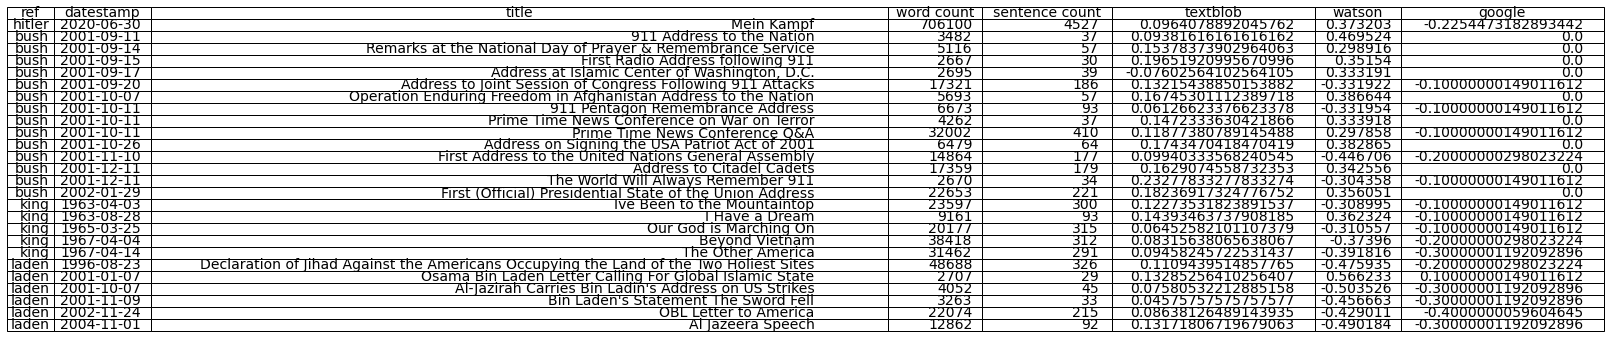

In [29]:
from matplotlib import pyplot as plt
df = sentiment_analytics.df
table = plt.table(cellText=df.values, colLabels=df.columns, loc='center')
table.auto_set_column_width(col=list(range(len(df.columns))))
table.set_fontsize(14)
plt.axis("OFF")
plt.show()
# table.properties()

plt.table

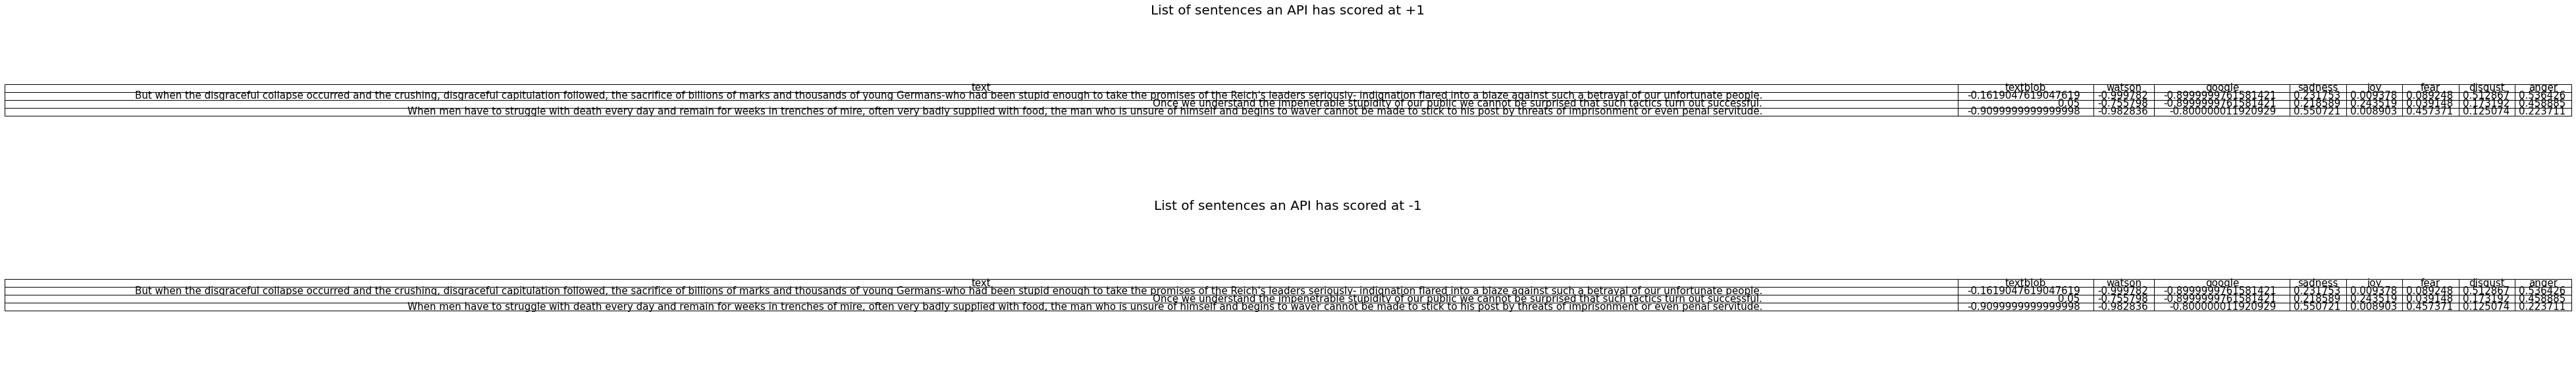

In [55]:
from matplotlib import pyplot as plt
import pandas as pd

orator = "bush"
text = 0
data = sentiment_analytics.minmax[orator][text]

plots = len([d for d in data.values() if d["sentences"]])

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

fig, axes = plt.subplots(plots, figsize=(20,5*plots))
for ax, sentdata in zip(axes, data.values()):
    ax.axis('off')
    ax.set_title(sentdata["explain"], fontsize = MEDIUM_SIZE)
    if sentdata["sentences"]:

        if isinstance(sentdata["sentences"], list):
            df = pd.DataFrame(sentdata["sentences"])
        if isinstance(sentdata["sentences"], dict):
            df = pd.DataFrame(sentdata["sentences"]).T
        
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
    table.set_fontsize(SMALL_SIZE)
    table.auto_set_column_width(col=list(range(len(df.columns))))


plt.show()

## Reviewing Sentence sores

In [35]:
import pandas as pd

agreement = {1 : {"assessment" : "assess the agreement between APIs", "score" : 0}, 
             2: {"assessment" : "assess the agreement between state-of-the-art APIs", "score" : 0},
             3 : {"assessment" : "assess agreement between Watson emotion and sentiment", "score" : 0}
            }

for orator in sentiment_analytics.values():
    
    for text in orator:
        
        for sentence in text["sentences"]:
            scores = sentence["scores"]
            
            # assessment 1: agreement between each 
            if all([i > 0 for i in scores.values()]) or all([i < 0 for i in scores.values()]):
                agreement[1]["score"] +=1
                
            # assessment 2: agreement between each state of the art
            sota = ["watson", "google"]
            if all([i > 0 for k, i in scores.items() if k in sota]) or all([i < 0 for k, i in scores.items() if k in sota]):
                agreement[2]["score"] +=1
            
            # sadness, joy, fear, disgust, anger
            api = "watson"
            pos_emotion = ["joy"]
            neg_emotion = ["sadness", "fear", "disgust", "anger"]
            watson_score = sentence["scores"]["watson"]
            emotions = sentence["emotion"]
            if all([watson_score > 0, max(emotions, key=emotions.get) in pos_emotion]) or all([watson_score < 0, max(emotions, key=emotions.get) in neg_emotion]):
                agreement[3]["score"] +=1
            
df = pd.DataFrame(agreement)       
for i, v in enumerate(df.values[1]):
    df.values[1][i] = f'{round(v*100/len(sentiment_analytics))}%'
df.T

,assessment,score
1,assess the agreement between APIs,22%
2,assess the agreement between state-of-the-art APIs,49%
3,assess agreement between Watson emotion and sentiment,52%


In [93]:
d = {"textblob" : +1, "watson" : +1, "google" : -1}
all([i > 0 for k, i in d.items() if k in ["watson", "google"]])

False

In [4]:
orator = "bush"
text = 4

emotion = sentiment_analytics[orator][text]["sentences"][32]["emotion"]
max(emotion, key=emotion.get)

'fear'